# Disclaimer

The below notebook contains extremely toxic and obscene words. None of them are intentional. They are present only to understand the data distribution and feature engineering.

# Quick Navigation

The aim of this jupyter notebook is to perform following operations on the Sentiment-140 dataset: 
1. [Data Preparation](#section-1)
2. [Exploratory Data Analysis (EDA)](#section-2)
3. [Data Pre-processing](#section-3)
4. [Modeling](#section-4)
5. [Model Evaluation](#section-5)
6. [Using the models to test on unseen data](#section-6)

# 1. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings
import string
import pickle
import time
import re

import nltk
from nltk.stem import WordNetLemmatizer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, classification_report


sns.set()
%matplotlib inline
warnings.filterwarnings('ignore')

# <a id='section-1'>2. Data Preparation</a>

## 2.1 [OPTIONAL] Download the dataset from the link specified [here](http://help.sentiment140.com/for-students)

Uncomment and run the cell below to download the dataset automatically and place it in the `data` folder.

In [2]:
# # Grab the dataset
# !wget 'http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip'

# !unzip ./trainingandtestdata.zip -d ./data/
# !rm ./trainingandtestdata.zip

# !mv ./data/training.1600000.processed.noemoticon.csv ./data/train.csv
# !mv ./data/testdata.manual.2009.06.14.csv ./data/test.csv

## 2.2 Load the data

In [3]:
DATASET_ENCODING = "ISO-8859-1"
column_names = ['target', 'id', 'date', 'flag', 'user', 'text']
train_data  = pd.read_csv('./data/train.csv', names=column_names, encoding=DATASET_ENCODING)

In [4]:
train_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
# Pick only 200K samples from the available 1.6M samples
train_data = pd.concat([train_data.iloc[:100000, :], train_data.iloc[-100000:, :]])
train_data.shape

(200000, 6)

In [6]:
# Check for any missing values
np.sum(train_data.isnull().any(axis=1))

0

Fortunately, there are no missing values.

# <a id='section-2'>3. Exploratory Data Analysis (EDA)</a>

## 3.1 Dataset statistics

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   target  200000 non-null  int64 
 1   id      200000 non-null  int64 
 2   date    200000 non-null  object
 3   flag    200000 non-null  object
 4   user    200000 non-null  object
 5   text    200000 non-null  object
dtypes: int64(2), object(4)
memory usage: 10.7+ MB


## 3.2 Data Visualization

In [8]:
print("Number of distinct target values : ", train_data['target'].nunique())
print("Distinct target values.          : ", train_data['target'].unique())

Number of distinct target values :  2
Distinct target values.          :  [0 4]


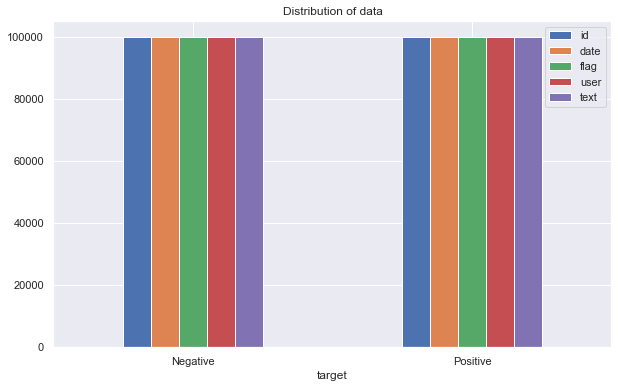

In [9]:
# Plotting the distribution for dataset.
ax = train_data.groupby('target').count().plot(kind='bar', title='Distribution of data', legend=True, figsize=(10, 6))
ax.set_xticklabels(['Negative', 'Positive'], rotation=0);

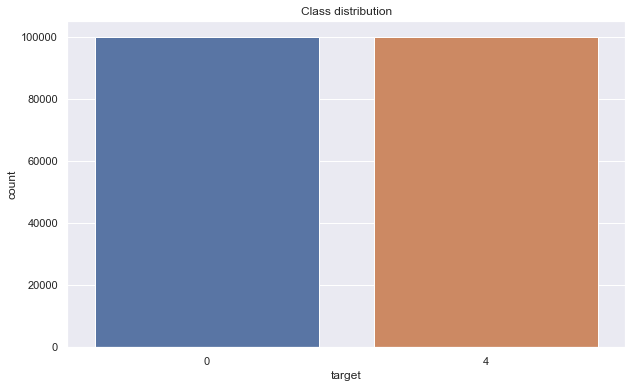

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='target', data=train_data)
plt.title('Class distribution');

From the above plot, we can clearly see that the dataset is balanced and has only two classes.

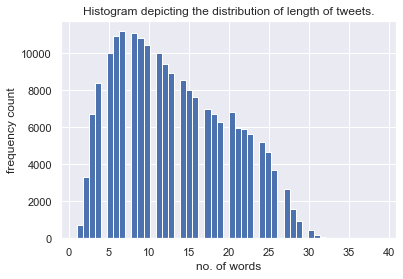

In [11]:
tweet_tokens = train_data["text"].str.split()
tweet_lengths = [len(tokens_list) for tokens_list in tweet_tokens]

plt.hist(tweet_lengths, bins=50)
plt.xlabel('no. of words')
plt.ylabel('frequency count')
plt.title("Histogram depicting the distribution of length of tweets.");

From the above histogram, we can clearly see that most of the tweets are under 30 words.

In [12]:
# Sample tweet with the least number of words
train_data["text"].iloc[np.argmin(tweet_lengths)]

'Agh...snow!!! '

In [13]:
# Sample tweet with the most number of words
train_data["text"].iloc[np.argmax(tweet_lengths)]

'4 I am high &amp; u can see. 4 I am lost &amp; u find me. 4 I am held &amp; u break free. Well I am am &amp; u can only wish to be of such a masterpiece. '

The above example motivates us to write better pre-processing methods.

# <a id='section-3'>4. Data Pre-processing</a>

For our problem, we only need the tweets and their corresponding sentiment. So, let's just store them in variables `X` and `y` respectively.

In [14]:
X = train_data['text']
y = train_data['target']

In [15]:
# Let's reassign target `4` to `1` to ease processing
desired_targets = {0: 0, 4: 1}
y = y.map(desired_targets)

In [16]:
X = list(X)
y = list(y)

## 4.1 Pre-processing

In [17]:
# Defining a dictionary containing most of the emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised', 
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy', 
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused', 
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

# Defining a list containing majority of the stopwords in English.
stopwords = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

punctuations = string.punctuation

In [18]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ramapinnimty/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [19]:
def preprocess(textdata):
    processedText = []

    # Create a Lemmatizer.
    lemmatizer = WordNetLemmatizer()

    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    usernamePattern   = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"

    for tweet in textdata:
        # Convert to lowercase.
        tweet = tweet.lower()

        # Replace all URLs with ' '.
        tweet = re.sub(urlPattern, ' ', tweet)

        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, emojis[emoji])

        # Replace @USERNAME with ' '.
        tweet = re.sub(usernamePattern, ' ', tweet)

        # Remove punctuations.
        translator = str.maketrans('', '', punctuations)
        tweet = tweet.translate(translator)

        # Replace all non-alphanumerics.
        tweet = re.sub(alphaPattern, " ", tweet)

        # Replace 3 or more consecutive letters with 2 letters.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            # Checking if the word is a stopword.
            if word not in stopwords:
                # Checking if the word is not a letter.
                if len(word) > 1:
                    # Lemmatizing the word.
                    word = lemmatizer.lemmatize(word)
                    tweetwords += (word + ' ')

        processedText.append(tweetwords)

    return processedText

In [20]:
start = time.time()
processedtext = preprocess(X)
print(f'Text Pre-processing complete.')
print(f'Time Taken: {round(time.time() - start)} seconds')

Text Pre-processing complete.
Time Taken: 15 seconds


## 4.2 Analysing the wordclouds

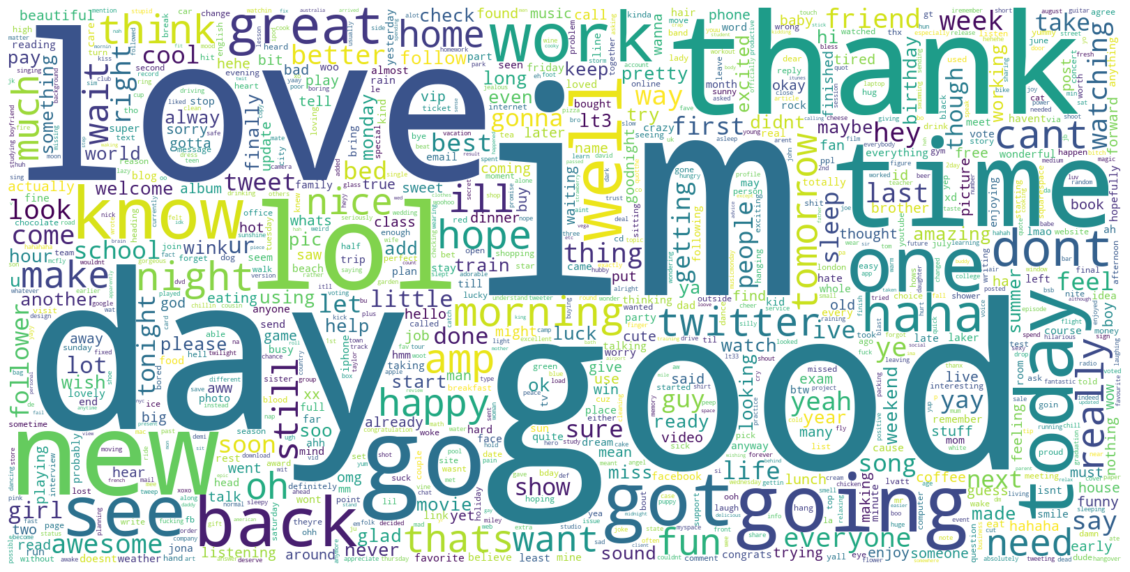

In [21]:
# Word cloud for positive words
data_pos = processedtext[100000:]
plt.figure(figsize=(20, 20))
word_cloud_pos = WordCloud(max_words=1000, width=1600, height=800, background_color="white", collocations=False).generate(" ".join(data_pos))
plt.imshow(word_cloud_pos, interpolation="bilinear")
plt.axis("off")
plt.show();

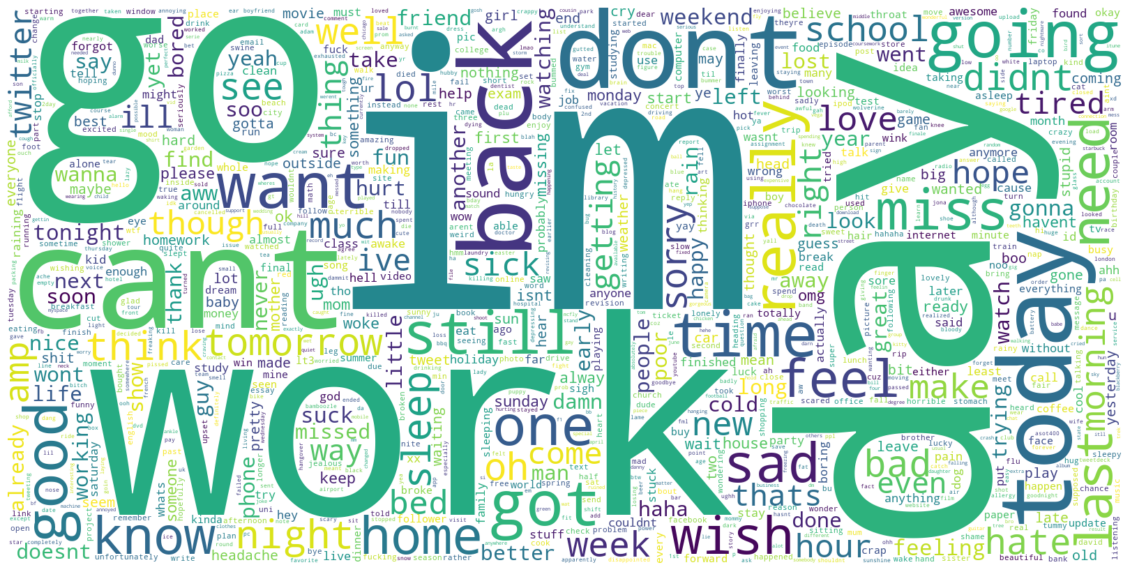

In [22]:
# Word cloud for negative words
data_neg = processedtext[:100000]
plt.figure(figsize=(20, 20))
word_cloud_neg = WordCloud(max_words=1000, width=1600, height=800, background_color="white", collocations=False).generate(" ".join(data_neg))
plt.imshow(word_cloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show();

# <a id='section-4'>5. Modeling</a>

## 5.1 Split the data into train and validation sets

In [23]:
X_train, X_val, y_train, y_val = train_test_split(processedtext, y, test_size=0.05, random_state=0)

## 5.2 Transforming data using TF-IDF Vectorizer

In [24]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features=50000, min_df=3, max_df=0.8)

In [25]:
# Fit
vectoriser.fit(X_train)
print('No. of features: ', len(vectoriser.get_feature_names()))

No. of features:  50000


In [26]:
# Transform
X_train = vectoriser.transform(X_train)
X_val  = vectoriser.transform(X_val)

In [27]:
file = open('./models/vectoriser-ngram-(1,2).pickle', 'wb')
pickle.dump(vectoriser, file)
file.close()

## 5.3 Model Training

### 5.3.1 K-Nearest Neighbors (KNN)

In [28]:
# KNN using GridSearchCV takes a lot of time to run. So I'll be using a simple and direct method intead.
best_acc = 0
best_k = 0
for k in [3, 5, 7, 10]:
    knn_model = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    knn_model.fit(X_train, y_train) # Time taken for train will be '0'
    start = time.time()
    y_pred = knn_model.predict(X_val)
    print(f'Prediction Time: {round(time.time() - start)} seconds')
    acc = accuracy_score(y_val, y_pred)
    print("The accuracy using k=" + str(k) + " : " + str(acc))

    if acc > best_acc:
        best_acc = acc
        best_k = k

Prediction Time: 67 seconds
The accuracy using k=3 : 0.6244
Prediction Time: 70 seconds
The accuracy using k=5 : 0.615
Prediction Time: 71 seconds
The accuracy using k=7 : 0.6131
Prediction Time: 70 seconds
The accuracy using k=10 : 0.6077


In [29]:
# Fit the model
knn_model_best = KNeighborsClassifier(n_neighbors=best_k, n_jobs=-1)
knn_model_best.fit(X_train, y_train)

KNeighborsClassifier(n_jobs=-1, n_neighbors=3)

In [30]:
file = open('./models/Sentiment-KNN-v1.pickle', 'wb')
pickle.dump(knn_model_best, file)
file.close()

### 5.3.2 Bernoulli Naïve Bayes

In [31]:
param_grid_bnb = {
    "alpha" : np.linspace(1e-7, 2, 5)
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

bnb_model_grid = GridSearchCV(estimator=BernoulliNB(), 
                             param_grid = param_grid_bnb, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

In [32]:
# Grid search
start = time.time()
bnb_model_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", bnb_model_grid.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Time Taken: 3 seconds
Best parameters: {'alpha': 2.0}


In [33]:
file = open('./models/Sentiment-BNB-v1.pickle', 'wb')
pickle.dump(bnb_model_grid, file)
file.close()

### 5.3.3 Linear Support Vector Machine (Linear-SVM)

In [34]:
param_grid_lsvc = {
    'C': [1, 10, 100, 1000], 
    'dual': [False]
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

lsvc_model_grid = GridSearchCV(estimator=LinearSVC(), 
                             param_grid = param_grid_lsvc, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

In [35]:
# Grid search
start = time.time()
lsvc_model_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", lsvc_model_grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time Taken: 237 seconds
Best parameters: {'C': 1, 'dual': False}


In [36]:
file = open('./models/Sentiment-LSVC-v1.pickle', 'wb')
pickle.dump(lsvc_model_grid, file)
file.close()

### 5.3.4 Logistic Regression

In [37]:
param_grid_lr = {
    'C': np.logspace(-4, 4, 10), 
    'solver': ['liblinear', 'lbfgs'], 
    'max_iter': [1000]
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

lr_model_grid = GridSearchCV(estimator=LogisticRegression(), 
                             param_grid = param_grid_lr, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

In [38]:
# Grid search
start = time.time()
lr_model_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", lr_model_grid.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Time Taken: 148 seconds
Best parameters: {'C': 2.782559402207126, 'max_iter': 1000, 'solver': 'liblinear'}


In [39]:
file = open('./models/Sentiment-LR-v1.pickle', 'wb')
pickle.dump(lr_model_grid, file)
file.close()

### 5.3.5 Random Forest

In [40]:
param_grid_rf = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [50]
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

rf_model_grid = GridSearchCV(estimator=RandomForestClassifier(), 
                             param_grid = param_grid_rf, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

In [41]:
# Grid search
start = time.time()
rf_model_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", rf_model_grid.best_params_)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Time Taken: 239 seconds
Best parameters: {'max_depth': 50, 'n_estimators': 200}


In [42]:
file = open('./models/Sentiment-RF-v1.pickle', 'wb')
pickle.dump(rf_model_grid, file)
file.close()

**NOTE:** The below code for MLP (5.3.6) will take nearly *2 hours* to run.

### 5.3.6 Multi-layer Perceptron (MLP)

In [43]:
param_grid_mlp = {
    'hidden_layer_sizes': [(10, 30, 10)], 
    'activation': ['tanh', 'relu'], 
    'solver': ['sgd'], 
    'alpha': [0.001, 0.05], 
    'learning_rate': ['constant']
    }

kfold = model_selection.KFold(3, shuffle=True, random_state=2)

mlp_model_grid = GridSearchCV(estimator=MLPClassifier(), 
                             param_grid = param_grid_mlp, 
                             refit=True, verbose=2, cv=kfold, n_jobs=-1)

In [44]:
# Grid search
start = time.time()
mlp_model_grid.fit(X_train, y_train)
print(f'Time Taken: {round(time.time() - start)} seconds')
print(f"Best parameters:", mlp_model_grid.best_params_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Time Taken: 6982 seconds
Best parameters: {'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (10, 30, 10), 'learning_rate': 'constant', 'solver': 'sgd'}


In [45]:
file = open('./models/Sentiment-MLP-v1.pickle', 'wb')
pickle.dump(mlp_model_grid, file)
file.close()

# <a id='section-5'>6. Model Evaluation</a>

In [46]:
def evaluate_model(X, y, y_pred):

    # Print the classification metrics
    print(classification_report(y, y_pred))

    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y, y_pred)

    categories = ['Negative', 'Positive']
    group_names = ['True Neg.','False Pos.', 'False Neg.','True Pos.']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    plt.figure()
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt = '', xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size':14}, labelpad=10)
    plt.ylabel("Actual values" , fontdict={'size':14}, labelpad=10)
    plt.title ("Confusion Matrix", fontdict={'size':18}, pad=20)

    fpr, tpr, thresholds = roc_curve(y, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show();

Model: K-Nearest Neighbors
--------------------------
              precision    recall  f1-score   support

           0       0.58      0.91      0.71      4988
           1       0.79      0.34      0.48      5012

    accuracy                           0.62     10000
   macro avg       0.68      0.63      0.59     10000
weighted avg       0.68      0.62      0.59     10000



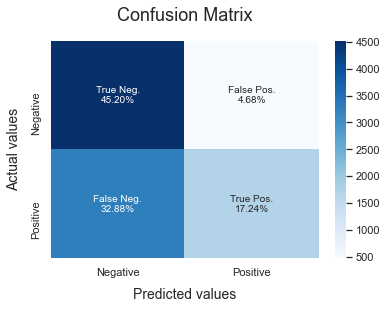

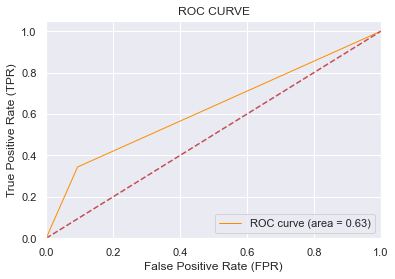

In [47]:
# Predict values for the Test dataset
y_pred = knn_model_best.predict(X_val)
print("Model: K-Nearest Neighbors")
print("--------------------------")
evaluate_model(X_val, y_val, y_pred)

Model: Bernoulli Naïve Bayes
----------------------------
              precision    recall  f1-score   support

           0       0.80      0.75      0.77      4988
           1       0.77      0.81      0.79      5012

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



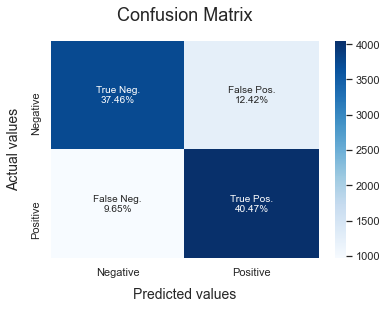

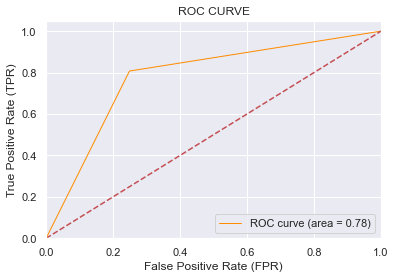

In [48]:
# Predict values for the Test dataset
y_pred = bnb_model_grid.predict(X_val)
print("Model: Bernoulli Naïve Bayes")
print("----------------------------")
evaluate_model(X_val, y_val, y_pred)

Model: Linear Support Vector Machine
------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.77      0.78      4988
           1       0.78      0.80      0.79      5012

    accuracy                           0.78     10000
   macro avg       0.78      0.78      0.78     10000
weighted avg       0.78      0.78      0.78     10000



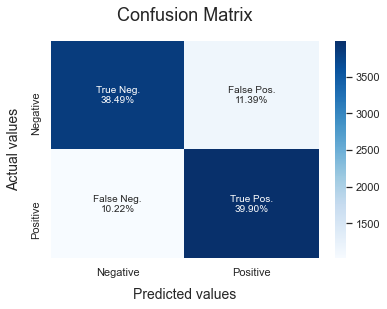

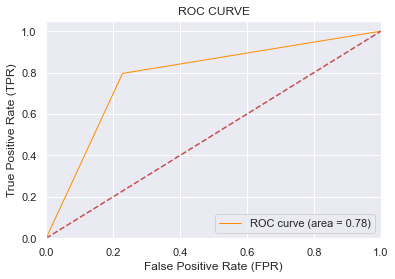

In [49]:
# Predict values for the Test dataset
y_pred = lsvc_model_grid.predict(X_val)
print("Model: Linear Support Vector Machine")
print("------------------------------------")
evaluate_model(X_val, y_val, y_pred)

Model: Logistic Regression
--------------------------
              precision    recall  f1-score   support

           0       0.80      0.78      0.79      4988
           1       0.79      0.81      0.80      5012

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



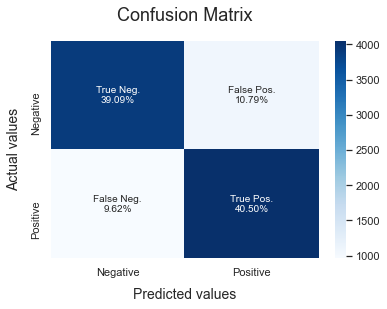

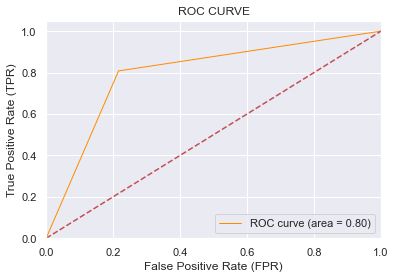

In [50]:
# Predict values for the Test dataset
y_pred = lr_model_grid.predict(X_val)
print("Model: Logistic Regression")
print("--------------------------")
evaluate_model(X_val, y_val, y_pred)

Model: Random Forest
--------------------
              precision    recall  f1-score   support

           0       0.78      0.70      0.74      4988
           1       0.73      0.81      0.77      5012

    accuracy                           0.75     10000
   macro avg       0.76      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



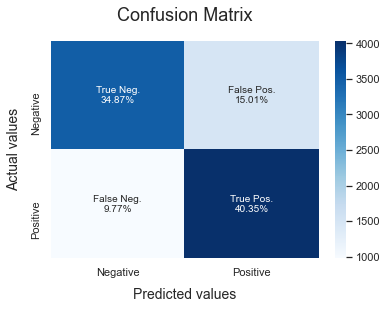

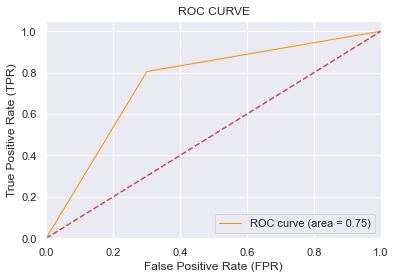

In [51]:
# Predict values for the Test dataset
y_pred = rf_model_grid.predict(X_val)
print("Model: Random Forest")
print("--------------------")
evaluate_model(X_val, y_val, y_pred)

Model: Multi-layer Perceptron
-----------------------------
              precision    recall  f1-score   support

           0       0.78      0.71      0.75      4988
           1       0.74      0.80      0.77      5012

    accuracy                           0.76     10000
   macro avg       0.76      0.76      0.76     10000
weighted avg       0.76      0.76      0.76     10000



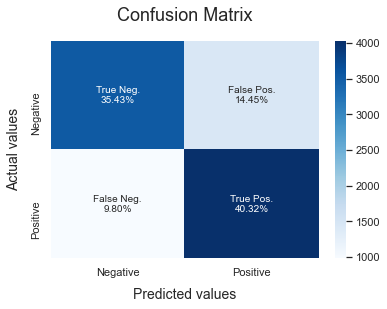

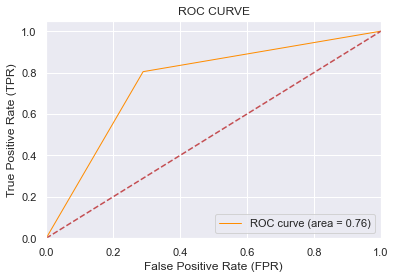

In [52]:
# Predict values for the Test dataset
y_pred = mlp_model_grid.predict(X_val)
print("Model: Multi-layer Perceptron")
print("-----------------------------")
evaluate_model(X_val, y_val, y_pred)

## <a id='section-6'>7. Using the models to test on unseen data</a>

In [53]:
def load_models(vectoriser_path, model_path):
    # Load the vectoriser.
    file = open(vectoriser_path, 'rb')
    vectoriser = pickle.load(file)
    file.close()

    # Load the model.
    file = open(model_path, 'rb')
    model = pickle.load(file)
    file.close()

    return vectoriser, model


def predict(vectoriser, model, text):
    # Predict the sentiment.
    textdata  = vectoriser.transform(preprocess(text))
    sentiment = model.predict(textdata)

    # Make a list of text along with its predicted sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text, pred))

    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text', 'sentiment'])
    df = df.replace([0, 1], ["Negative", "Positive"])

    return (df, sentiment)

In [54]:
test_data   = pd.read_csv('./data/test.csv', names=column_names, encoding=DATASET_ENCODING)

In [55]:
test_data = test_data[['target', 'text']]

# Drop rows with 'neutral' sentiment
test_data = test_data[test_data.target != 2]
print("Test data shape: ", test_data.shape)

test_data['target'] = test_data['target'].map({0: 0, 4: 1})

Test data shape:  (359, 2)


In [56]:
X_test = test_data["text"].to_numpy()
y_test = test_data["target"].to_numpy()

In [57]:
vectoriser_path = './models/vectoriser-ngram-(1,2).pickle'
model_path      = './models/Sentiment-LR-v1.pickle' # Pick the best model

vectoriser, model = load_models(vectoriser_path, model_path)
df, predictions = predict(vectoriser, model, X_test)
print(df)
print()
print("The test accuracy of the best model (Logistic Regression) is: ", round(accuracy_score(y_test, predictions)*100, 1), "%")


                                                  text sentiment
0    @stellargirl I loooooooovvvvvveee my Kindle2. ...  Negative
1    Reading my kindle2...  Love it... Lee childs i...  Positive
2    Ok, first assesment of the #kindle2 ...it fuck...  Positive
3    @kenburbary You'll love your Kindle2. I've had...  Positive
4    @mikefish  Fair enough. But i have the Kindle2...  Positive
..                                                 ...       ...
354  After using LaTeX a lot, any other typeset mat...  Negative
355  On that note, I hate Word. I hate Pages. I hat...  Negative
356  Ahhh... back in a *real* text editing environm...  Negative
357  Trouble in Iran, I see. Hmm. Iran. Iran so far...  Positive
358  Reading the tweets coming out of Iran... The w...  Negative

[359 rows x 2 columns]

The test accuracy of the best model (Logistic Regression) is:  78.3 %


The link to our Google Drive project repository is [here](https://drive.google.com/drive/folders/1wNmR1kUgrMsfSYadeFWJwi36p1v4YOTr?usp=sharing).

**References**
- https://www.aiperspectives.com/twitter-sentiment-analysis/
- https://stackabuse.com/python-for-nlp-sentiment-analysis-with-scikit-learn/
- https://towardsdatascience.com/social-media-sentiment-analysis-part-ii-bcacca5aaa39
- https://www.analyticsvidhya.com/blog/2020/04/beginners-guide-exploratory-data-analysis-text-data/
- https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
- https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- https://medium.com/analytics-vidhya/how-to-improve-naive-bayes-9fa698e14cba
- https://www.kaggle.com/viznrvn/optimal-parameters-for-svc-using-gridsearch
- https://www.kaggle.com/enespolat/grid-search-with-logistic-regression
- https://panjeh.medium.com/scikit-learn-hyperparameter-optimization-for-mlpclassifier-4d670413042b
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://medium.com/@lukei_3514/dealing-with-contractions-in-nlp-d6174300876b